In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as sp
%config InlineBackend.figure_format = 'svg'
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

TRACKER = False
TRACKERMATTIA = True

header = ['T GPU Upload', 'T Send Pack', 'T Recv Pack', 'T End Render',
          'Delta T CUDA', 'Delta T SendRecv', 'Delta T Render',
          'Delta T CUDA CudaEvent', 'Delta T Render OpenGL', 'Delta T TOT']
labels = [r'$\Delta T_{CUDA}^{QTtime}$', r'$\Delta T_{SendRecv}^{QTtime}$', r'$\Delta T_{Render}^{QTtime}$',
          r'$\Delta T_{CUDA}^{CudaEv}$', r'$\Delta T_{Render}^{OGLtime}$', r'$\Delta T_{TOT}$']
# labels = [r'$\Delta T_{CUDA}^{CPU}$', r'$\Delta T_{SendRecv}^{CPU}$', r'$\Delta T_{Render}^{CPU}$',
#           r'$\Delta T_{CUDA}^{GPU}$', r'$\Delta T_{Render}^{GPU}$', r'$\Delta T_{TOT}$']

# path = 'C:/Users/Mattia Mencagli/Documents/DATA/Latenze/'
# names = ['Original_16-07-2025_multi_misGPU_latency_algo', 'Original_16-07-2025_multi_misGPU_latency_noalgo', 
#          'Refactor_24-07-2025_multi_misGPU_latency_algo_clean', 'Refactor_24-07-2025_multi_misGPU_latency_noalgo',
#          'Refactor_24-07-2025_multi_misGPU_latency_algo']
path = 'C:/Users/Mattia Mencagli/Documents/DATA/Latenze/nuovi_files/'
names = ['pca-appConAlgo/latency_3_clean', 'pca-appNoAlgo/latency_3',
         'core-gui-appConAlgo/latency_3_clean', 'core-gui-appNoAlgo/latency_3',
         'core-gui-appConAlgo/latency_3', 'pca-appConAlgo/latency_3']
delimeter = ";"

if TRACKER:
    labels = ['tracker']
    path = 'C:/Users/Mattia Mencagli/Documents/DATA/Latenze/Tracker/'
    names = ['tracker_latency', 'tracker_latency1']
elif TRACKERMATTIA:
    labels = ['tracker']
    path = 'C:/Users/Mattia Mencagli/Documents/DATA/Latenze/TrackerMattia/T/'
    names = ['tracker_osdon_roimax',  'tracker_osdoff_roimax', 'tracker_osdon_roimid',
             'tracker_osdoff_roimid', 'tracker_osdon_roimin',  'tracker_osdoff_roimin']
    delimeter = ","

namebars = [f'PCA-U\nAlgo ON', f'PCA-U\nAlgo OFF', f'PCA-CG\nAlgo ON', f'PCA-CG\nAlgo OFF']
pathfigs = path+'figs/'

Nn = len(names)
Nl = len(labels)
# name_idx  = {name: i for i, name in enumerate(namebars)}
# label_idx = {label: i for i, label in enumerate(labels)}

BINS = np.zeros((Nn,Nl),dtype=int) + 15
# PER PLOT CONFRONTO CLEAN E NO CLEAN
# BINS[4,0] = 50; BINS[2,0] = 40
off  = 0

def Rsquare(y_data, y_fit):
    return 1 - (np.sum((y_data-y_fit)**2) / np.sum((y_data-np.mean(y_data))**2))
    
def read_lat(path, names, B, O):
    Bmax = np.max(B)
    LAT = []
    TSTAMPS = []
    HCOUNTS  = np.zeros((Nn,Nl,Bmax))
    HEDGES   = np.zeros((Nn,Nl,Bmax+1))
    HCENTERS = np.zeros((Nn,Nl,Bmax)) 
    PAR = np.zeros((Nn,Nl,2)); 
    RSQ = np.zeros((Nn,Nl))
    for i,name in enumerate(names):
        LAT.append((np.genfromtxt(path+name+'.csv', delimiter=delimeter)[O:,:]).T)
        LEN = len(LAT[i][0,:])#; print(LEN)
        summ = np.reshape((np.sum(LAT[i][4:7,:],axis=0)),(1,LEN))
        LAT[i] = np.append(LAT[i], summ, axis=0)
        if TRACKERMATTIA: #from ns to ms
            LAT[i] /= 1e6
        TSTAMPS.append(LAT[i][0:4,:].reshape(-1,order='F') - LAT[i][0,0])
        for j in range(Nl):
            Bins = B[i,j]
            HCOUNTS[i,j,:Bins], HEDGES[i,j,:Bins+1] = np.histogram(LAT[i][j+4,:], bins=Bins, density=True)
            HCENTERS[i,j,:] = 0.5 * (HEDGES[i,j,:-1] + HEDGES[i,j,1:])
            PAR[i,j,:] = sp.fit(LAT[i][j+4,:])
            RSQ[i,j] = Rsquare(HCOUNTS[i,j,:Bins], sp.pdf(HCENTERS[i,j,:Bins], *PAR[i,j,:]))
    return LAT, TSTAMPS, HCOUNTS, HEDGES, HCENTERS, PAR, RSQ

# def read_lat_AutoBins(path, names, O):
#     Bmax = 0
#     LAT = [] ; HCOUNTS = []; HEDGES = [] ; HCENTERS = []
#     PAR = np.zeros((Nn,Nl,2))
#     RSQ = np.zeros((Nn,Nl))
#     for i,name in enumerate(names):
#         LAT.append((np.genfromtxt(path+name+'.csv', delimiter=';')[O:,:]).T)
#         summ = np.reshape((np.sum(LAT[i][4:,:],axis=0)),(1,len(LAT[i][0,:])))
#         LAT[i] = np.append(LAT[i], summ, axis=0)
#         for j in range(Nl):
#             hc, he = np.histogram(LAT[i][j+4,:], bins='auto', density=True)
#             HCOUNTS.append(list(hc)); HEDGES.append(list(he))
#             HCENTERS.append(list(0.5 * (he[:-1] + he[1:])))
#             PAR[i,j,:] = sp.fit(LAT[i][j+4,:])
#             RSQ[i,j] = Rsquare(hc, sp.pdf(HCENTERS[-1], *PAR[i,j,:]))
#             Bmax = max(Bmax, len(hc))
#     HCOUNTS  = np.reshape(np.array([row + [0] * (Bmax - len(row)) for row in HCOUNTS]),    (Nn,Nl,Bmax))
#     HEDGES   = np.reshape(np.array([row + [0] * (Bmax + 1 - len(row)) for row in HEDGES]), (Nn,Nl,Bmax+1))
#     HCENTERS = np.reshape(np.array([row + [0] * (Bmax - len(row)) for row in HCENTERS]),   (Nn,Nl,Bmax))
#     return LAT, HCOUNTS, HEDGES, HCENTERS, PAR, RSQ

latency, Tstamps, hist_counts, hist_edges, hist_centers, params, Rsq = read_lat(path, names,  BINS, off)

for i,name in enumerate(names):
    print("%s --- N lines = %d"%(name, len(latency[i][0,:])))

tracker_osdon_roimax --- N lines = 1821
tracker_osdoff_roimax --- N lines = 1826
tracker_osdon_roimid --- N lines = 2451
tracker_osdoff_roimid --- N lines = 1499
tracker_osdon_roimin --- N lines = 2078
tracker_osdoff_roimin --- N lines = 1879


IndexError: index 2 is out of bounds for axis 1 with size 1

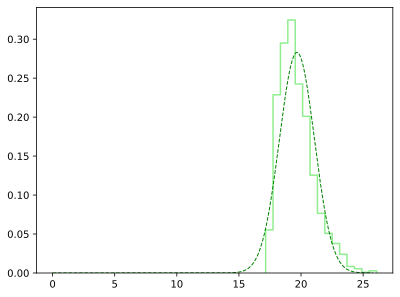

In [6]:
lw = 1.5
col = ['lightgreen', 'lightblue', 'orange', 'pink', 'grey', 'green', 'blue', 'red', 'magenta', 'black']
# plotlist = [0,2,3,4,1] # refer to labels to check what index to plot
Xlim = (-3,46)
Ylim = (0,0.45)

def comparison_distr(i, code, nome, plotlist, XLIM, YLIM):
    _ = plt.figure(i+100)
    for idx,j in enumerate(plotlist):
        X = np.linspace(0,max(hist_centers[i,j,:]),500)
        # lab = r'%s : Fit ($\mu$=%dms, $R^2=%.2f$)'%(labels[j],params[i,j,0],Rsq[i,j])
        lab = r'%s : Fit ($\mu$=%dms)'%(labels[j],params[i,j,0])
        _ = plt.stairs(hist_counts[i,j,:], hist_edges[i,j,:], color=col[idx], linewidth=lw, label=r'%s : Data Hist'%labels[j])
        _ = plt.plot(X, sp.pdf(X, *params[i,j,:]), color=col[idx+5], linestyle='--', linewidth=lw-0.5, label=lab)
    # _ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    _ = plt.legend()
    _ = plt.xlim(XLIM)
    _ = plt.ylim(YLIM)
    _ = plt.ylabel('Normalized counts (Area=1)')
    _ = plt.xlabel('time [ms]')
    _ = plt.title('Times\' Distributions & Gaussian Fits [%s, %s]'%(code,nome))
    _ = plt.savefig(pathfigs+'CompTimesDistr_multi_%s_%s.svg'%(code,nome.replace(" ", "-")), bbox_inches='tight', format='svg')

comparison_distr(0, 'PCA-U',  'Algo ON',  [0,2,3,4],   Xlim, Ylim)
comparison_distr(1, 'PCA-U',  'Algo OFF', [0,2,3,4],   Xlim, Ylim)
comparison_distr(2, 'PCA-CG', 'Algo ON',  [0,2,3,4,1], Xlim, Ylim)
comparison_distr(3, 'PCA-CG', 'Algo OFF', [0,2,3,4,1], Xlim, Ylim)

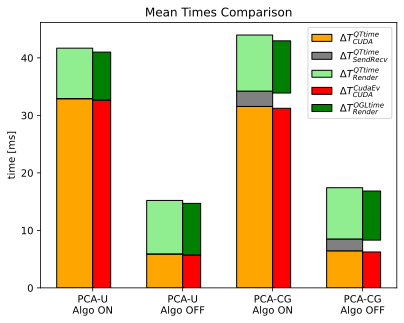

In [3]:
bw = 0.4
ec = 'black'
col = ['orange', 'grey', 'lightgreen', 'red', 'green']
index = [0,1,2,3]

def barplotcomp(COMP=False):
    if COMP: al = 'edge'
    else:    al = 'center'
    L = len(namebars)
    _ = plt.figure(1000)
    prev = np.zeros((L))
    for i in [0,1,2]:
        _ = plt.bar(index, params[0:L,i,0], -bw, bottom=prev, color=col[i], label=labels[i], edgecolor=ec, align=al)
        prev += params[0:L,i,0]
    if COMP:
        prev = np.zeros((L))
        for i in [3,4]:
            _ = plt.bar(index, params[0:L,i,0], +bw*0.5, bottom=prev, color=col[i], label=labels[i], edgecolor=ec, align=al)
            prev += params[0:L,i,0] + params[0:L,1,0]
    _ = plt.legend()
    _ = plt.ylabel('time [ms]')
    _ = plt.xticks(index, namebars, rotation=0)
    _ = plt.title('Mean Times Comparison')
    _ = plt.savefig(pathfigs+'CompAllTimesBars.svg', bbox_inches='tight', format='svg')

barplotcomp(True)

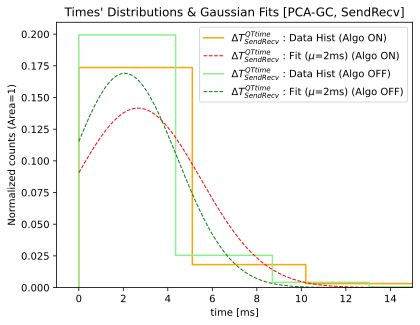

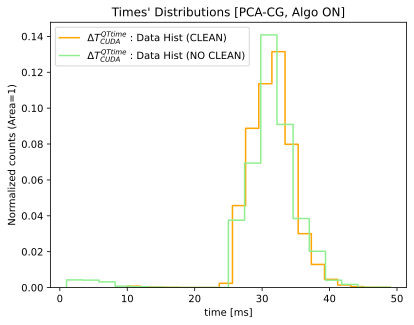

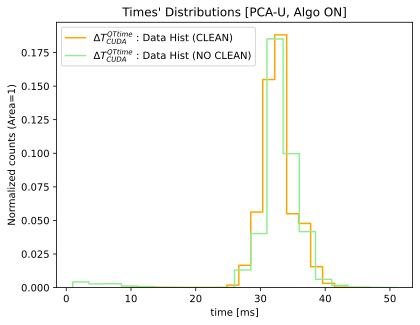

In [4]:
lw = 1.5
col = ['orange', 'lightgreen', 'red', 'green', 'blue']

def plot_SendRecv():
    _ = plt.figure(50)
    j = 1
    for idx,i in enumerate([2,3]):
        if i==2: ALGO=' (Algo ON)'
        else:    ALGO=' (Algo OFF)'
        X = np.linspace(0,max(hist_centers[i,j,:]),500)
        lab = r'%s : Data Hist'%labels[j]+ALGO
        _ = plt.stairs(hist_counts[i,j,:], hist_edges[i,j,:], color=col[idx], linewidth=lw, label=lab)
        lab = r'%s : Fit ($\mu$=%dms)'%(labels[j],params[i,j,0])+ALGO
        _ = plt.plot(X, sp.pdf(X, *params[i,j,:]), color=col[idx+2], linestyle='--', linewidth=lw-0.5, label=lab)
    _ = plt.legend()
    _ = plt.xlim((-1,15))
    _ = plt.ylabel('Normalized counts (Area=1)')
    _ = plt.xlabel('time [ms]')
    _ = plt.title('Times\' Distributions & Gaussian Fits [PCA-GC, SendRecv]')
    _ = plt.savefig(pathfigs+'CompTimesDistr_SendRecv.svg', bbox_inches='tight', format='svg')

plot_SendRecv()

def tempiERR(l, code, nome, figi):
    _ = plt.figure(figi)
    j = 0
    for idx,i in enumerate(l):
        if i<3: CLEAN= ' (CLEAN)'
        else:   CLEAN= ' (NO CLEAN)'
        X = np.linspace(0,max(hist_centers[i,j,:]),500)
        lab = r'%s : Data Hist'%labels[j]+CLEAN
        _ = plt.stairs(hist_counts[i,j,:], hist_edges[i,j,:], color=col[idx], linewidth=lw, label=lab)
    _ = plt.legend()
    _ = plt.ylabel('Normalized counts (Area=1)')
    _ = plt.xlabel('time [ms]')
    _ = plt.title('Times\' Distributions [%s, %s]'%(code,nome))
    _ = plt.savefig(pathfigs+code+'_CompTimesDistr_TempiSbagliati.svg', bbox_inches='tight', format='svg')

tempiERR([2,4], 'PCA-CG', 'Algo ON', 51)
tempiERR([0,5], 'PCA-U', 'Algo ON', 52)

correlazione CUDA-SendRecv   = -0.196456
correlazione CUDA-Render     = +0.003457
correlazione SendRecv-Render = +0.156697


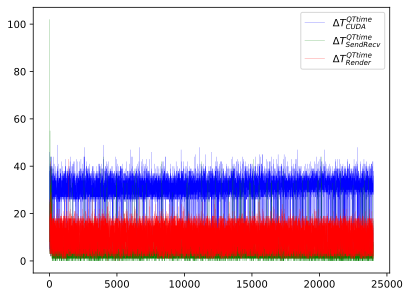

In [5]:
sw = 0.2

def tstamps_plot(i):
    Lmax = len(latency[i][4,:])
    l = 0 ; L = Lmax
    # l = 400 ; L = 500
    X = np.linspace(l,L,L-l)
    P = latency[i][:,l:L]
    _ = plt.figure(200)
    # _ = plt.scatter(X,P[4]-0.0, s=sw, color='blue' , label=labels[0])
    # _ = plt.scatter(X,P[5]-0.3, s=sw, color='green', label=labels[1])
    # _ = plt.scatter(X,P[6]-0.6, s=sw, color='red'  , label=labels[2])
    _ = plt.plot(X,P[4], linewidth=sw, color='blue' , label=labels[0])
    _ = plt.plot(X,P[5], linewidth=sw, color='green', label=labels[1])
    _ = plt.plot(X,P[6], linewidth=sw, color='red'  , label=labels[2])
    _ = plt.legend()
    print("correlazione CUDA-SendRecv   = %+f"%np.corrcoef(P[4],P[5])[0,1])
    print("correlazione CUDA-Render     = %+f"%np.corrcoef(P[4],P[6])[0,1])
    print("correlazione SendRecv-Render = %+f"%np.corrcoef(P[5],P[6])[0,1])

tstamps_plot(4)

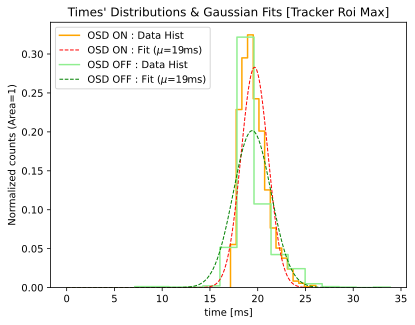

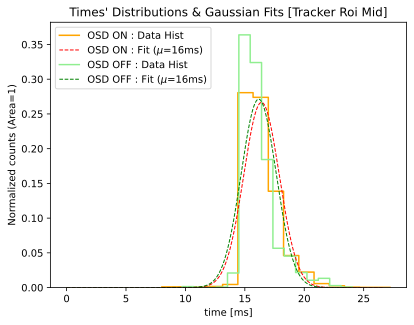

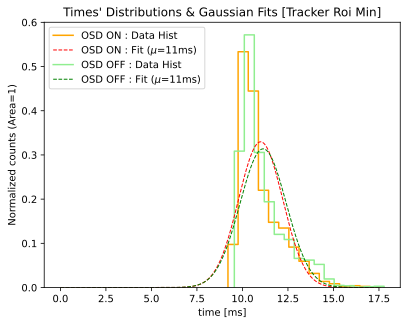

In [34]:
lw = 1.5
col1 = ['orange', 'lightgreen']
col2 = ['red', 'green']
if TRACKERMATTIA:
    labs = ['OSD ON', 'OSD OFF']
elif TRACKER:
    labs = ['ROI 0', 'ROI 1']

def tracker_plot(ff, choosen_names, case):
    j = 0
    _ = plt.figure(ff+300)
    for a,name in enumerate(choosen_names):
        i = a + ff
        X = np.linspace(0,max(hist_centers[i,j,:]),500)
        lab = r'%s : Fit ($\mu$=%dms)'%(labs[i%2],params[i,j,0])
        _ = plt.stairs(hist_counts[i,j,:], hist_edges[i,j,:], color=col1[i%2], linewidth=lw, label=r'%s : Data Hist'%labs[i%2])
        _ = plt.plot(X, sp.pdf(X, *params[i,j,:]), color=col2[i%2], linestyle='--', linewidth=lw-0.5, label=lab)
    _ = plt.legend()
    _ = plt.ylabel('Normalized counts (Area=1)')
    _ = plt.xlabel('time [ms]')
    #_ = plt.xlim([0,20])
    _ = plt.title('Times\' Distributions & Gaussian Fits [Tracker Roi ' + case + ']')
    _ = plt.savefig(pathfigs+'tracker_plot_Roi'+case+'.svg', bbox_inches='tight', format='svg')
    _ = plt.show(True)

tracker_plot(0, names[0:2], 'Max')
tracker_plot(2, names[2:4], 'Mid')
tracker_plot(4, names[4:],  'Min')
#tracker_plot(0, names,  '')

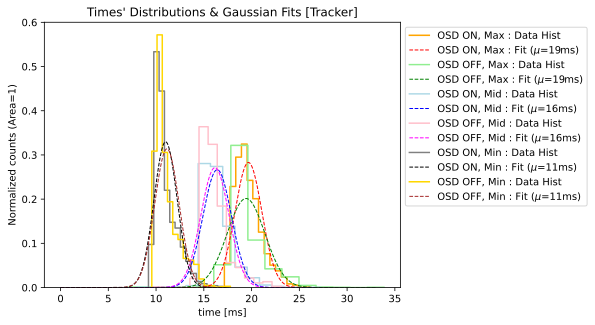

In [46]:
lw = 1.5
col1 = ['orange', 'lightgreen', 'lightblue', 'pink', 'grey', 'gold']
col2 = ['red', 'green', 'blue', 'magenta', 'black', 'brown']
labs = ['OSD ON', 'OSD OFF']
roilabs = ['Max', 'Mid', 'Min']

def tracker_plot():
    j = 0
    _ = plt.figure(400)
    for i,name in enumerate(names):
        X = np.linspace(0,max(hist_centers[i,j,:]),500)
        lab = r'%s, %s : Fit ($\mu$=%dms)'%(labs[i%2],roilabs[(int(i/2))%3],params[i,j,0])
        _ = plt.stairs(hist_counts[i,j,:], hist_edges[i,j,:], color=col1[i], linewidth=lw, label=r'%s, %s : Data Hist'%(labs[i%2],roilabs[(int(i/2))%3]))
        _ = plt.plot(X, sp.pdf(X, *params[i,j,:]), color=col2[i], linestyle='--', linewidth=lw-0.5, label=lab)
    _ = plt.legend(bbox_to_anchor=(1, 1))
    _ = plt.ylabel('Normalized counts (Area=1)')
    _ = plt.xlabel('time [ms]')
    #_ = plt.xlim([0,20])
    _ = plt.title('Times\' Distributions & Gaussian Fits [Tracker]')
    _ = plt.savefig(pathfigs+'tracker_plot.svg', bbox_inches='tight', format='svg')
    _ = plt.show(True)

tracker_plot()